In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time

sys.path.append('../code/')
from interpolation import cfl_interpolation
from diusst_eulera import diusst_eulera
from diusst_eulerb import diusst_eulerb
from diusst_rk4a import diusst_rk4a
from diusst_rk4b import diusst_rk4b
from diusst_eulerc import diusst_eulerc
from diusst_ts import diusst_ts

## Settings

In [2]:
# Fit parameters
param_names = ['kappa', 'mu', 'attenu', 'k0', 'gamma']
parama = np.array([1e-4, 1e-4, 2.5])
paramb = np.array([3e-4, 1e-4, 2.5])
paramc = np.array([2e-4, 1e-4, 2.5, 0.95, 2])
param_max = np.array([7e-4, 1e-4, 2.5])

# DIUSST model
scheme = 'euler'
dz0 = 0.10
ngrid = 50
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10

# Dataset
data_path = '../data/bayesian_training/'
data_filename = 'training_minnett_ssterr03-10_humid10.csv'
data_interval = [1149,1471]

## Data

In [18]:
# Load dataset
data_orig = pd.read_csv(data_path+data_filename)[data_interval[0]:data_interval[1]]

# interpolate to meet CFL condition
data, dtlist, idxlist = cfl_interpolation(data_orig, dz0=dz0, ngrid=ngrid,
        a=1, b=0, k_eddy_max=param_max[0], maxwind=maxwind,)
        #save=output_path+timestamp+'_'+run_id)


# extract data
ftemp = np.mean(data['ftemp'].to_numpy(np.float64))
sst_data = data['sst'].to_numpy(np.float64) - data['ftemp'].to_numpy(np.float64)
sst_err = data['sst_err'].to_numpy(np.float64)
times = data['times'].to_numpy(np.float64)
wind = data['wind'].to_numpy(np.float64)
atemp = data['atemp'].to_numpy(np.float64)
swrad = data['swrad'].to_numpy(np.float64)
humid = data['humid'].to_numpy(np.float64)

+++ Variable time-step interpolation +++
Interpolated dataset has 639643 time steps with average length 1.606 s.
Constant dt interpolation would require dt = 0.099 s --> 2901234 steps.
Computation time will be reduced by 77.953 %
++++++++++++++++++++++++++++++++++++++++


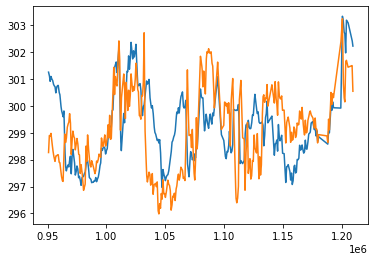

In [4]:
plt.plot(times,atemp)
plt.plot(times,atemp-data['ftemp']+ftemp)

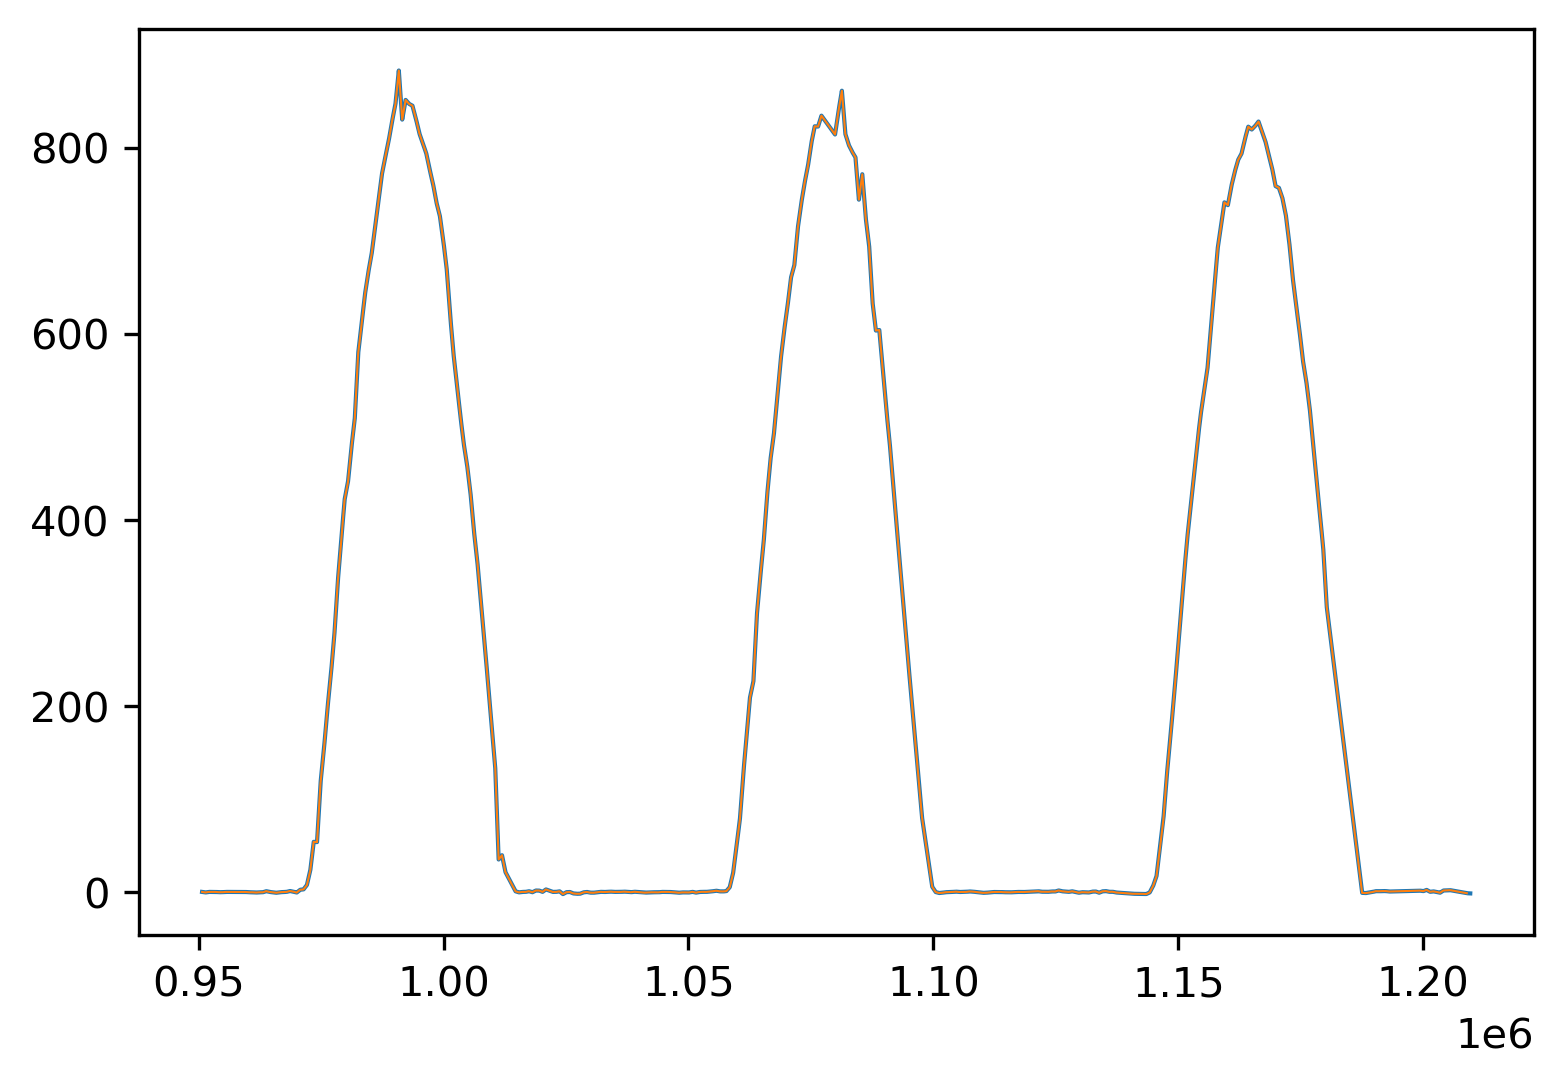

In [5]:
fig, ax = plt.subplots(dpi=300)
ax.plot(times,swrad,lw=1)
ax.plot(data_orig['times'][:-1],swrad[idxlist],lw=.5)

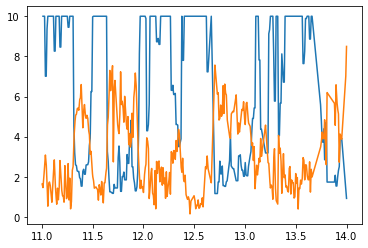

In [6]:
plt.plot(data_orig['times'][1:]/86400,dtlist)
plt.plot(times/86400,wind)
plt.show()

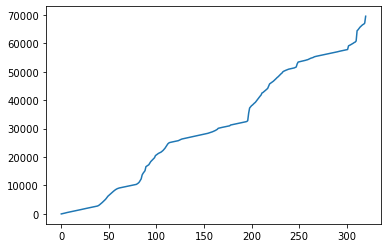

In [7]:
plt.plot(idxlist)

In [8]:
print(len(data_orig['times']))
len(idxlist)
print(data_orig['times'].to_numpy(np.float64)[-2:]/86400)

322
[13.99190278 13.99996389]


In [9]:
for i in range(len(idxlist)-1):
    print(i,'    ',round(data_orig['times'].to_numpy(np.float64)[i]/86400,8), '    ', round(times[idxlist[i]]/86400,8))

0      11.00362778      11.00362778
1      11.01155833      11.01155833
2      11.01948611      11.01948611
3      11.02741111      11.02741111
4      11.03543333      11.03543333
5      11.04346389      11.04346389
6      11.05149444      11.05149444
7      11.05942778      11.05942778
8      11.06735833      11.06735833
9      11.07529444      11.07529444
10      11.08333056      11.08333056
11      11.09126389      11.09126389
12      11.09919167      11.09919167
13      11.10721667      11.10721667
14      11.11514167      11.11514167
15      11.12306667      11.12306667
16      11.13099722      11.13099722
17      11.13893056      11.13893056
18      11.14696389      11.14696389
19      11.15499722      11.15499722
20      11.163025      11.163025
21      11.17095278      11.17095278
22      11.17888056      11.17888056
23      11.18694167      11.18694167
24      11.19503056      11.19503056
25      11.20311944      11.20311944
26      11.21100833      11.21100833
27      11.2191

## Run models

In [26]:
simstart = time.time()

kappa, mu, attenu = parama
imp_a = diusst_ts(data_orig['atemp'],data_orig['swrad'],data_orig['times'],dz=0.1, u_data=data_orig['wind'],T_0=ftemp,mixing=mu,k_eddy=kappa,attenu=attenu,mixing_type=2)

print(time.time()-simstart)

KeyError: 0

In [19]:
simstart = time.time()

kappa, mu, attenu = parama
eul_a = diusst_eulera(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

16.945488929748535


In [11]:
simstart = time.time()

kappa, mu, attenu = paramb
eul_b = diusst_eulerb(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

2.3697290420532227


In [12]:
simstart = time.time()

kappa, mu, attenu, k0, gamma = paramc
eul_c = diusst_eulerc(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=5e-4, mu=0.01, attenu=2.5, k0=0.99, gamma=10,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

2.1059446334838867


In [20]:
simstart = time.time()

kappa, mu, attenu = parama
rk4_a = diusst_rk4a(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

61.047749042510986


In [14]:
simstart = time.time()

kappa, mu, attenu = paramb
rk4_b = diusst_rk4b(
            times, atemp, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
            k_eddy=kappa, mu=mu, attenu=attenu,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)

print(time.time()-simstart)

8.049364566802979


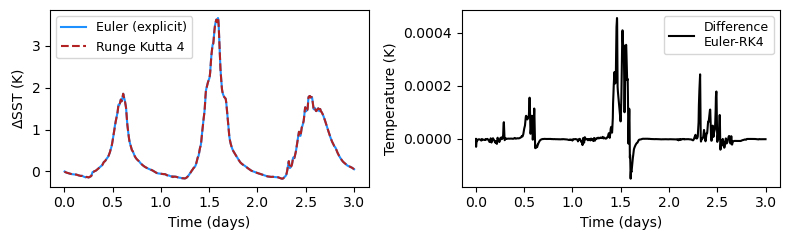

In [48]:
fig, [ax,ax2] = plt.subplots(1,2,dpi=100,figsize=(8,2.5))
#ax.plot(times/86400,sst_data, label='Data')
ax.plot(times/86400-11,eul_a[0][:,0]-ftemp,label='Euler (explicit)',c='dodgerblue')
#ax.plot(times/86400,eul_b[0][:,0]-ftemp,label='Euler B')
#ax.plot(times/86400,eul_c[0][:,0]-ftemp,label='Euler C')
ax.plot(times/86400-11,rk4_a[0][:,0]-ftemp,'--',label='Runge Kutta 4',c='firebrick')
#ax.plot(times/86400,rk4_b[0][:,0]-ftemp,'--',label='RK4 B')

ax2.plot(times/86400-11,eul_a[0][:,0]-rk4_a[0][:,0],c='k',label='Difference\nEuler-RK4')

ax.legend(loc='upper left',fontsize=9)
ax2.legend(fontsize=9)

ax.set(xlabel='Time (days)',ylabel='$\Delta$SST (K)')
ax2.set(xlabel='Time (days)',ylabel='Temperature (K)')
fig.tight_layout()

#plt.savefig('../../Masterarbeit/thesis/figs/euler-rk4.pdf',bbox_inches='tight')

No handles with labels found to put in legend.


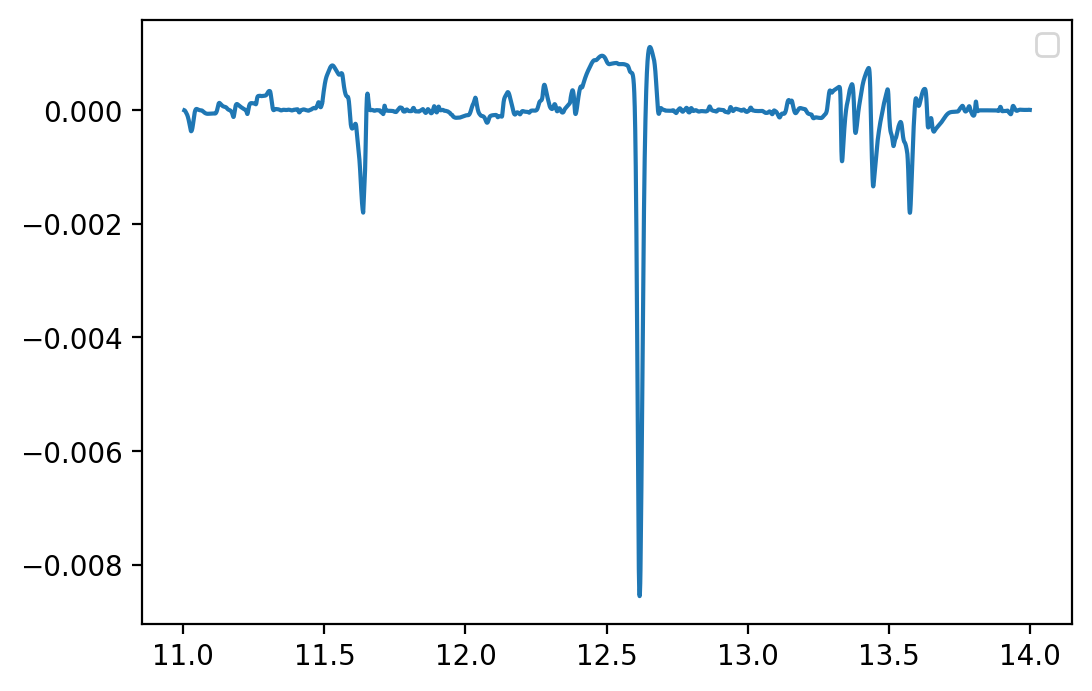

In [16]:
fig, ax = plt.subplots(dpi=200)
#ax.plot(times/86400,sst_data, label='Data')
#ax.plot(times/86400,eul_a[0][:,0]-ftemp,label='Euler A')
ax.plot(times/86400,eul_b[0][:,0]-rk4_b[0][:,0])
#ax.plot(times/86400,rk4_a[0][:,0]-ftemp,'--',label='RK4 A')
#ax.plot(times/86400,rk4_b[0][:,0]-ftemp,lw=0.5,label='RK4 B')
ax.legend()


[(-5.0, 0.0)]

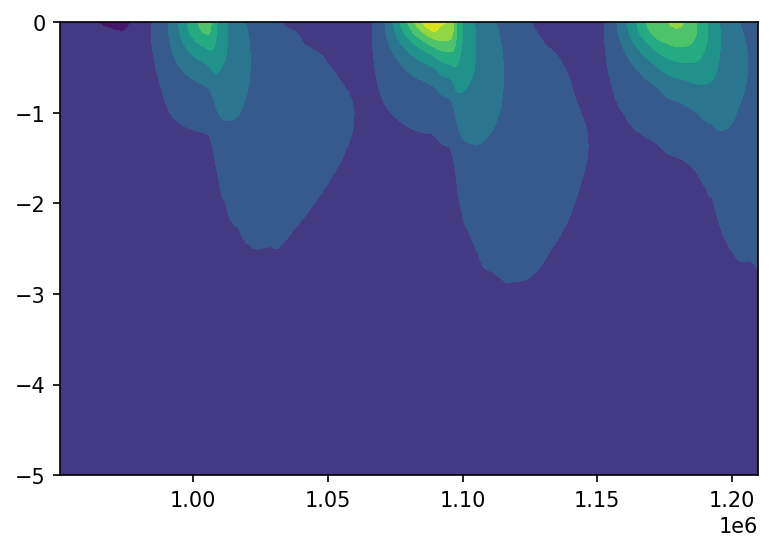

In [76]:
fig, ax = plt.subplots(dpi=150)
ax.contourf(times,eul_c[1],eul_c[0].transpose(),levels=10)
ax.set(ylim=(-5,0))

In [14]:
q = [0]
q.append(1)
q

[0, 1]

In [26]:
q = [1,2,3,4,5,6,7]
q[:-1]

[1, 2, 3, 4, 5, 6]